#  Backward Elimination Step by Step

* Backward Elimination mantığını oturtmak için yazıyorum

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [197]:
data = pd.read_csv('insurance.csv')

In [198]:
data.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [199]:
X = data[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
y = data['charges']


*kategorik veri var bunu numerik yapmamız gerekiyor*

In [200]:
X = pd.get_dummies(X, columns=['sex', 'smoker', 'region'], drop_first=True)

In [201]:
# Sadece boolean ve sayısal sütunlara dönüştürme
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

In [202]:
X.head(3)

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.90,0,0,1,0,0,1
1,18,33.77,1,1,0,0,1,0
2,28,33.00,3,1,0,0,1,0


# Eksik veri kontrolü

In [203]:
print(X.isnull().sum())

age                 0
bmi                 0
children            0
sex_male            0
smoker_yes          0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64


# Veri Ölçekleme

In [204]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print(X_scaled.head())

        age       bmi  children  sex_male  smoker_yes  region_northwest  \
0 -1.438764 -0.453320 -0.908614 -1.010519    1.970587         -0.566418   
1 -1.509965  0.509621 -0.078767  0.989591   -0.507463         -0.566418   
2 -0.797954  0.383307  1.580926  0.989591   -0.507463         -0.566418   
3 -0.441948 -1.305531 -0.908614  0.989591   -0.507463          1.765481   
4 -0.513149 -0.292556 -0.908614  0.989591   -0.507463          1.765481   

   region_southeast  region_southwest  
0         -0.611324          1.765481  
1          1.635795         -0.566418  
2          1.635795         -0.566418  
3         -0.611324         -0.566418  
4         -0.611324         -0.566418  


# Veri Analizi ve Görselleştirme

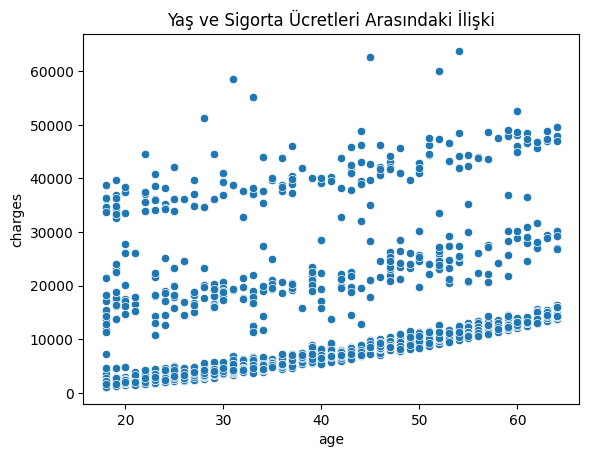

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

# Yaş ve maliyetler arasındaki ilişkiyi görselleştirme
sns.scatterplot(data=data, x='age', y='charges')
plt.title('Yaş ve Sigorta Ücretleri Arasındaki İlişki')
plt.show()

# Uç Değerlerin Tespiti ve Yönetimi

In [206]:
Q1 = X['bmi'].quantile(0.25)  # 1. çeyrek
Q3 = X['bmi'].quantile(0.75)  # 3. çeyrek
IQR = Q3 - Q1  # Çeyrekler arası açıklık
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [207]:
# Uç değerleri tespit et
outliers = X[(X['bmi'] < lower_bound) | (X['bmi'] > upper_bound)]

# Uç değerleri görüntüle
print("Uç değerler:")
print(outliers)

Uç değerler:
      age    bmi  children  sex_male  smoker_yes  region_northwest  \
116    58  49.06         0         1           0                 0   
286    46  48.07         2         0           0                 0   
401    47  47.52         1         1           0                 0   
543    54  47.41         0         0           1                 0   
847    23  50.38         1         1           0                 0   
860    37  47.60         2         0           1                 0   
1047   22  52.58         1         1           1                 0   
1088   52  47.74         1         1           0                 0   
1317   18  53.13         0         1           0                 0   

      region_southeast  region_southwest  
116                  1                 0  
286                  0                 0  
401                  1                 0  
543                  1                 0  
847                  1                 0  
860                  0      

In [208]:
X['bmi'] = np.clip(X['bmi'], lower_bound, upper_bound)
print(X.head())

   age     bmi  children  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0         0           1                 0   
1   18  33.770         1         1           0                 0   
2   28  33.000         3         1           0                 0   
3   33  22.705         0         1           0                 1   
4   32  28.880         0         1           0                 1   

   region_southeast  region_southwest  
0                 0                 1  
1                 1                 0  
2                 1                 0  
3                 0                 0  
4                 0                 0  


# Şimdi Backward Elimination Yapıyorum

In [209]:
import statsmodels.api as sm

# Bias terimini ekle
X = sm.add_constant(X)

In [210]:
def backward_elimination(X, y, significance_level=0.05):
    initial_features = X.columns.tolist()
    while len(initial_features) > 0:
        model = sm.OLS(y, X[initial_features]).fit()
        p_values = model.pvalues
        print("\nP-Değerleri:")
        print(p_values)
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            remove_feature = p_values.idxmax()
            print(f"Çıkarılan Özellik: {remove_feature} (p-değeri: {max_p_value})")
            initial_features.remove(remove_feature)
        else:
            break
    return initial_features

# Özelliklerin seçilmesi
selected_features = backward_elimination(X, y)
print(f"\nSeçilen Özellikler: {selected_features}")


P-Değerleri:
const               4.018416e-32
age                 1.403201e-88
bmi                 5.031565e-31
children            5.981167e-04
sex_male            7.062260e-01
smoker_yes          0.000000e+00
region_northwest    4.578095e-01
region_southeast    3.112518e-02
region_southwest    4.377886e-02
dtype: float64
Çıkarılan Özellik: sex_male (p-değeri: 0.7062260251848451)

P-Değerleri:
const               6.564051e-33
age                 9.505989e-89
bmi                 5.076141e-31
children            6.088342e-04
smoker_yes          0.000000e+00
region_northwest    4.586118e-01
region_southeast    3.116042e-02
region_southwest    4.384662e-02
dtype: float64
Çıkarılan Özellik: region_northwest (p-değeri: 0.4586118495952507)

P-Değerleri:
const               1.184133e-35
age                 8.381349e-89
bmi                 5.003095e-31
children            6.546966e-04
smoker_yes          0.000000e+00
region_southeast    3.941483e-02
region_southwest    5.741460e-02
dtype: flo

# p-value NaN geliyor bunun sebebi küçük bir veri setinde çalışmak olabilir şimdi Multicollinearity'yi kontrol edeceğim

Korelasyon Matrisi:
                       age       bmi  children  sex_male  smoker_yes  \
age               1.000000  0.111930  0.042469 -0.020856   -0.025019   
bmi               0.111930  1.000000  0.013700  0.044802    0.003146   
children          0.042469  0.013700  1.000000  0.017163    0.007673   
sex_male         -0.020856  0.044802  0.017163  1.000000    0.076185   
smoker_yes       -0.025019  0.003146  0.007673  0.076185    1.000000   
region_northwest -0.000407 -0.135672  0.024806 -0.011156   -0.036945   
region_southeast -0.011642  0.268556 -0.023066  0.017117    0.068498   
region_southwest  0.010016 -0.005087  0.021914 -0.004184   -0.036945   

                  region_northwest  region_southeast  region_southwest  
age                      -0.000407         -0.011642          0.010016  
bmi                      -0.135672          0.268556         -0.005087  
children                  0.024806         -0.023066          0.021914  
sex_male                 -0.011156     

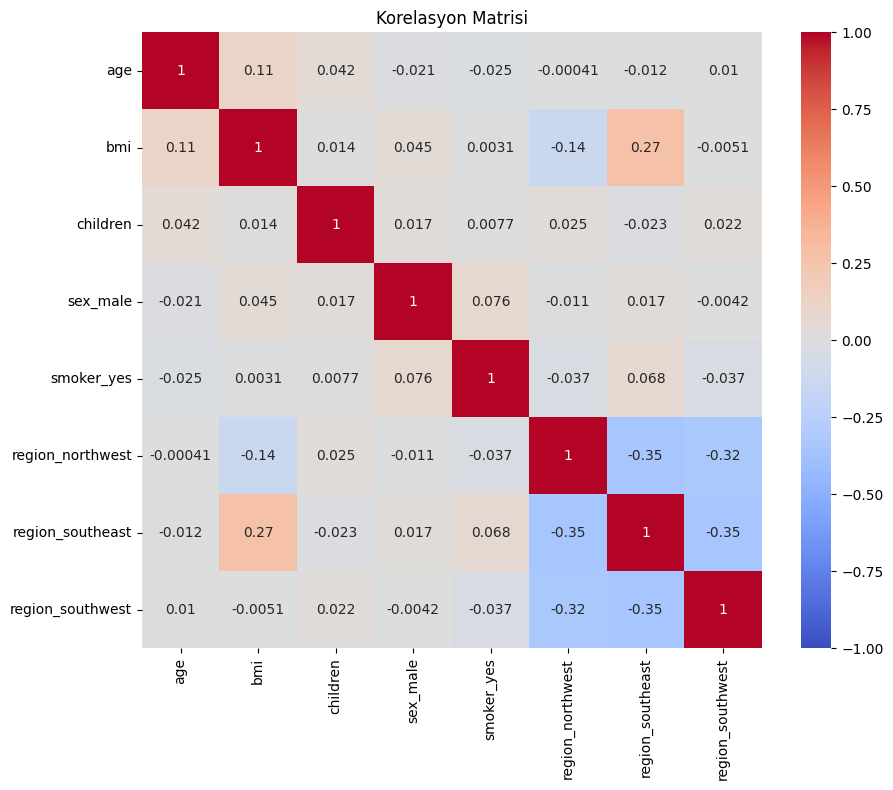

In [211]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Korelasyon matrisi
correlation_matrix = X.drop(columns='const').corr()

print("Korelasyon Matrisi:")
print(correlation_matrix)

# VIF
X_vif = X.drop(columns='const')
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("\nVIF Değerleri:")
print(vif_data)

# Korelasyon matrisi görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelasyon Matrisi')
plt.show()

# Açıklamalar

**VIF, her bir özelliğin diğer özelliklerle olan çoklu ilişki derecesini ölçer. Genellikle şu şekilde yorumlanır:**

*   VIF < 5: Genellikle çoklu ilişki (multicollinearity) problemi yok.
*   5 ≤ VIF < 10: Orta derecede çoklu ilişki problemi olabilir.
*   VIF ≥ 10: Yüksek derecede çoklu ilişki problemi var, bu özelliklerin modelden çıkarılması gerekebilir.





# Yorumlar



1. bmi için VIF değeri 11.42: Bu, bmi özelliğinin diğer özelliklerle yüksek derecede çoklu ilişkiye sahip olduğunu gösterir. bmi'nin yüksek VIF değeri, bu özelliğin modeldeki diğer özelliklerle güçlü bir ilişkiye sahip olduğunu ve bu nedenle multicollinearity (çoklu ilişki) sorunlarına neden olabileceğini gösterir.

2. age için VIF değeri 7.72: Bu da yüksek bir VIF değeri ve potansiyel olarak çoklu ilişki sorununu işaret eder.

3. Diğer özelliklerin VIF değerleri genellikle 1 ile 2 arasında, bu da düşük çoklu ilişki gösterir.



# Ne yapılabilir
bmi ve age özelliklerini çıkarmak istemiyorum bunun yerine dönüştürme yapacağım

# Ridge Regression (L2 Regularizasyonu)
**Ridge Regression, multicollinearity'yi yönetmenin en yaygın yollarından biridir.** Ridge Regression, modelin ağırlıklarına ceza ekler ve bu, yüksek VIF değerlerine sahip özelliklerin etkisini azaltabilir.

In [212]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Özellikleri standardize et ve Ridge Regression uygulama
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Özellikleri standardize et
    ('regressor', Ridge(alpha=1.0))  # Ridge Regression uygula
])

pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('regressor', Ridge())])

In [213]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X.copy()
X_vif = X_vif.drop(columns='const', errors='ignore')

# VIF hesaplama
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("\nVIF Değerleri:")
print(vif_data)



VIF Değerleri:
            Feature        VIF
0               age   7.718745
1               bmi  11.415326
2          children   1.810429
3          sex_male   2.002599
4        smoker_yes   1.261246
5  region_northwest   1.891190
6  region_southeast   2.264651
7  region_southwest   1.961961


# Görüyoruz ki Ridge Regression kullanmak VIF değerimizi düşürmüş ve Multicollinearity'yi azaltmış veri ön işleme sürecini bitirdik şimdi model seçip kullanabiliriz ve tahmin yapabiliriz

**Tahmin Yapma ve Skor Hesaplama**
Ridge regression kullandık şimdi skor hesaplamaları yapacağız belki başka modeller de deneriz

In [214]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pipeline.fit(X, y)

y_pred = pipeline.predict(X)

# Performans metrikleri
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 36488005.693780705
Mean Absolute Error (MAE): 4175.771903186424
R-squared (R2): 0.7510078008839336


 **Ridge Regression ile %75 başarı sağlıyoruz**

# Random Forest ile Tahmin

In [217]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Tahmin yap
rf_predictions = rf_model.predict(X_test)

# Model performansını değerlendirme
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Random Forest performans metrikleri
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("\nRandom Forest Model Sonuçları:")
print(f"Mean Squared Error (MSE): {rf_mse}")
print(f"Mean Absolute Error (MAE): {rf_mae}")
print(f"R-squared (R2): {rf_r2}")


Random Forest Model Sonuçları:
Mean Squared Error (MSE): 20832219.05606841
Mean Absolute Error (MAE): 2546.8765441452474
R-squared (R2): 0.8658139177312872


**Random Forest ile çok yüksek başarı sağladık bu modeli kullanacaksan Ridge Regression'u veri ön işlemede kullanmış gibi düşünebiliriz**

# Şimdi Test yapıyoruz 2. kişinin gerçek değerini ve bizim modelimizin bulduğu değeri görelim

In [218]:
# Test veri setinden 2. kişiyi seç
person_index = 1  # 0 tabanlı index ile ikinci kişiyi seçiyoruz
person_features = X_test.iloc[person_index]  # Özellikleri al
actual_value = y_test.iloc[person_index]  # Gerçek değeri al

# Tahmin yap
person_prediction = rf_model.predict(person_features.values.reshape(1, -1))[0]

# Sonuçları yazdır
print(f"Gerçek Değer: {actual_value}")
print(f"Tahmin Edilen Değer: {person_prediction}")

Gerçek Değer: 5272.1758
Tahmin Edilen Değer: 5593.410838500003


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
